In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
SEED=55555

from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from imblearn.over_sampling import RandomOverSampler,SMOTE
from sklearn.cluster import KMeans

from xgboost import XGBClassifier,XGBRegressor
from lightgbm import LGBMClassifier,LGBMRegressor

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

from xgboost import plot_importance
import  matplotlib.pyplot  as plt



# concat the dataset to do feature engineering 

In [ ]:
train_values = pd.read_csv('sample_data/train_values.csv')
test = pd.read_csv('sample_data/test_values.csv')
train_values['train_data']=1
test['train_data'] = 0
f_dta = pd.concat([train_values,test],axis=0).reset_index(drop=True,inplace=False)
#concat data to do feature engineering.
#and every new feature will be add to this data_frame.

train_label = pd.read_csv('sample_data/train_labels.csv')

In [ ]:
f_dta

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,train_data
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,0,0,1
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,0,0,1
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,0,0,1
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,0,0,1
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347464,310028,4,605,3623,3,70,20,6,t,r,...,0,0,0,0,0,0,0,0,0,0
347465,663567,10,1407,11907,3,25,6,7,n,r,...,0,0,0,0,0,0,0,0,0,0
347466,1049160,22,1136,7712,1,50,3,3,t,r,...,0,0,0,0,0,0,0,0,0,0
347467,442785,6,1041,912,2,5,9,5,t,r,...,0,0,0,0,0,0,0,0,0,0


# check null, NAs

In [ ]:
f_dta.info(null_counts=True)
#no null found

<ipython-input-125-0c0c3b489966>:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  f_dta.info(null_counts=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347469 entries, 0 to 347468
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             347469 non-null  int64 
 1   geo_level_1_id                          347469 non-null  int64 
 2   geo_level_2_id                          347469 non-null  int64 
 3   geo_level_3_id                          347469 non-null  int64 
 4   count_floors_pre_eq                     347469 non-null  int64 
 5   age                                     347469 non-null  int64 
 6   area_percentage                         347469 non-null  int64 
 7   height_percentage                       347469 non-null  int64 
 8   land_surface_condition                  347469 non-null  object
 9   foundation_type                         347469 non-null  object
 10  roof_type                               347469 non-null 

# do some feature engineer
### decription from Drivern data
<br>- geo_level_1_id, geo_level_2_id, geo_level_3_id (type: int):<br> geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). Possible values: level 1: 0-30, level 2: 0-1427, level 3: 0-12567.<br>
<br>- count_floors_pre_eq (type: int):<br>number of floors in the building before the earthquake.<br>
<br>- age (type: int):<br> age of the building in years.<br>
<br>- area_percentage (type: int):<br> normalized area of the building footprint.<br>
<br>- height_percentage (type: int):<br> normalized height of the building footprint.<br>
<br>- land_surface_condition (type: categorical):<br> surface condition of the land where the building was built. Possible values: n, o, t.<br>
<br>- foundation_type (type: categorical):<br> type of foundation used while building. Possible values: h, i, r, u, w.<br>
<br>- roof_type (type: categorical):<br> type of roof used while building. Possible values: n, q, x.<br>
<br>- ground_floor_type (type: categorical):<br> type of the ground floor. Possible values: f, m, v, x, z.<br>
<br>- other_floor_type (type: categorical):<br> type of constructions used in higher than the ground floors (except of roof). Possible values: j, q, s, x.<br>
<br>- position (type: categorical):<br> position of the building. Possible values: j, o, s, t.<br>
<br>- plan_configuration (type: categorical):<br> building plan configuration. Possible values: a, c, d, f, m, n, o, q, s, u.<br>
<br>- has_superstructure_adobe_mud (type: binary):<br> flag variable that indicates if the superstructure was made of Adobe/Mud.<br>
<br>- has_superstructure_mud_mortar_stone (type: binary):<br> flag variable that indicates if the superstructure was made of Mud Mortar Stone.<br>
<br>- has_superstructure_stone_flag (type: binary):<br> flag variable that indicates if the superstructure was made of Stone.<br>
<br>- has_superstructure_cement_mortar_stone (type: binary):<br> flag variable that indicates if the superstructure was made of Cement Mortar <br>- Stone.<br>
<br>- has_superstructure_mud_mortar_brick (type: binary):<br> flag variable that indicates if the superstructure was made of Mud Mortar Brick.<br>
<br>- has_superstructure_cement_mortar_brick (type: binary):<br> flag variable that indicates if the superstructure was made of Cement Mortar <br>- Brick.<br>
<br>- has_superstructure_timber (type: binary):<br> flag variable that indicates if the superstructure was made of Timber.<br>
<br>- has_superstructure_bamboo (type: binary):<br> flag variable that indicates if the superstructure was made of Bamboo.<br>
<br>- has_superstructure_rc_non_engineered (type: binary):<br> flag variable that indicates if the superstructure was made of non-engineered reinforced concrete.<br>
<br>- has_superstructure_rc_engineered (type: binary):<br> flag variable that indicates if the superstructure was made of engineered reinforced concrete.<br>
<br>- has_superstructure_other (type: binary):<br> flag variable that indicates if the superstructure was made of any other material.<br>
<br>- legal_ownership_status (type: categorical):<br> legal ownership status of the land where building was built. Possible values: a, r, v, w.<br>
<br>- count_families (type: int):<br> number of families that live in the building.<br>
<br>- has_secondary_use (type: binary):<br> flag variable that indicates if the building was used for any secondary purpose.<br>
<br>- has_secondary_use_agriculture (type: binary):<br> flag variable that indicates if the building was used for agricultural purposes.<br>
<br>- has_secondary_use_hotel (type: binary):<br> flag variable that indicates if the building was used as a hotel.<br>
<br>- has_secondary_use_rental (type: binary):<br> flag variable that indicates if the building was used for rental purposes.<br>
<br>- has_secondary_use_institution (type: binary):<br> flag variable that indicates if the building was used as a location of any institution.<br>
<br>- has_secondary_use_school (type: binary):<br> flag variable that indicates if the building was used as a school.<br>
<br>- has_secondary_use_industry (type: binary):<br> flag variable that indicates if the building was used for industrial purposes.<br>
<br>- has_secondary_use_health_post (type: binary):<br> flag variable that indicates if the building was used as a health post.<br>
<br>- has_secondary_use_gov_office (type: binary):<br> flag variable that indicates if the building was used fas a government office.<br>
<br>- has_secondary_use_use_police (type: binary):<br> flag variable that indicates if the building was used as a police station.<br>
<br>- has_secondary_use_other (type: binary):<br> flag variable that indicates if the building was secondarily used for other purposes.<br>

###  finding
####  type
some of columns has been one-hot encoding,<br>
others are int,<br>
the others are categorical. <br>

#### useful
columns covers geography,building_structure,building_usage,<br>
it is quite enough.

# check outliner & inspect trends or pattern & Feature Engineering

In [ ]:
import seaborn as sns

In [ ]:
f_dta.describe()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,train_data
count,3.474690e+05,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,...,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000,347469.000000
mean,5.259136e+05,13.897315,701.838052,6258.846760,2.130579,26.538814,8.017014,5.434799,0.088972,0.762077,...,0.033686,0.008136,0.000958,0.000363,0.001053,0.000167,0.000138,0.000078,0.005065,0.749998
std,3.043545e+05,8.032597,412.875674,3646.950564,0.727761,73.527749,4.388646,1.915555,0.284704,0.425813,...,0.180421,0.089832,0.030943,0.019039,0.032438,0.012919,0.011753,0.008815,0.070990,0.433015
min,4.000000e+00,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.619990e+05,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.260710e+05,12.000000,706.000000,6271.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,7.895880e+05,21.000000,1050.000000,9414.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.052934e+06,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### damage_grade

<Axes: xlabel='damage_grade', ylabel='count'>

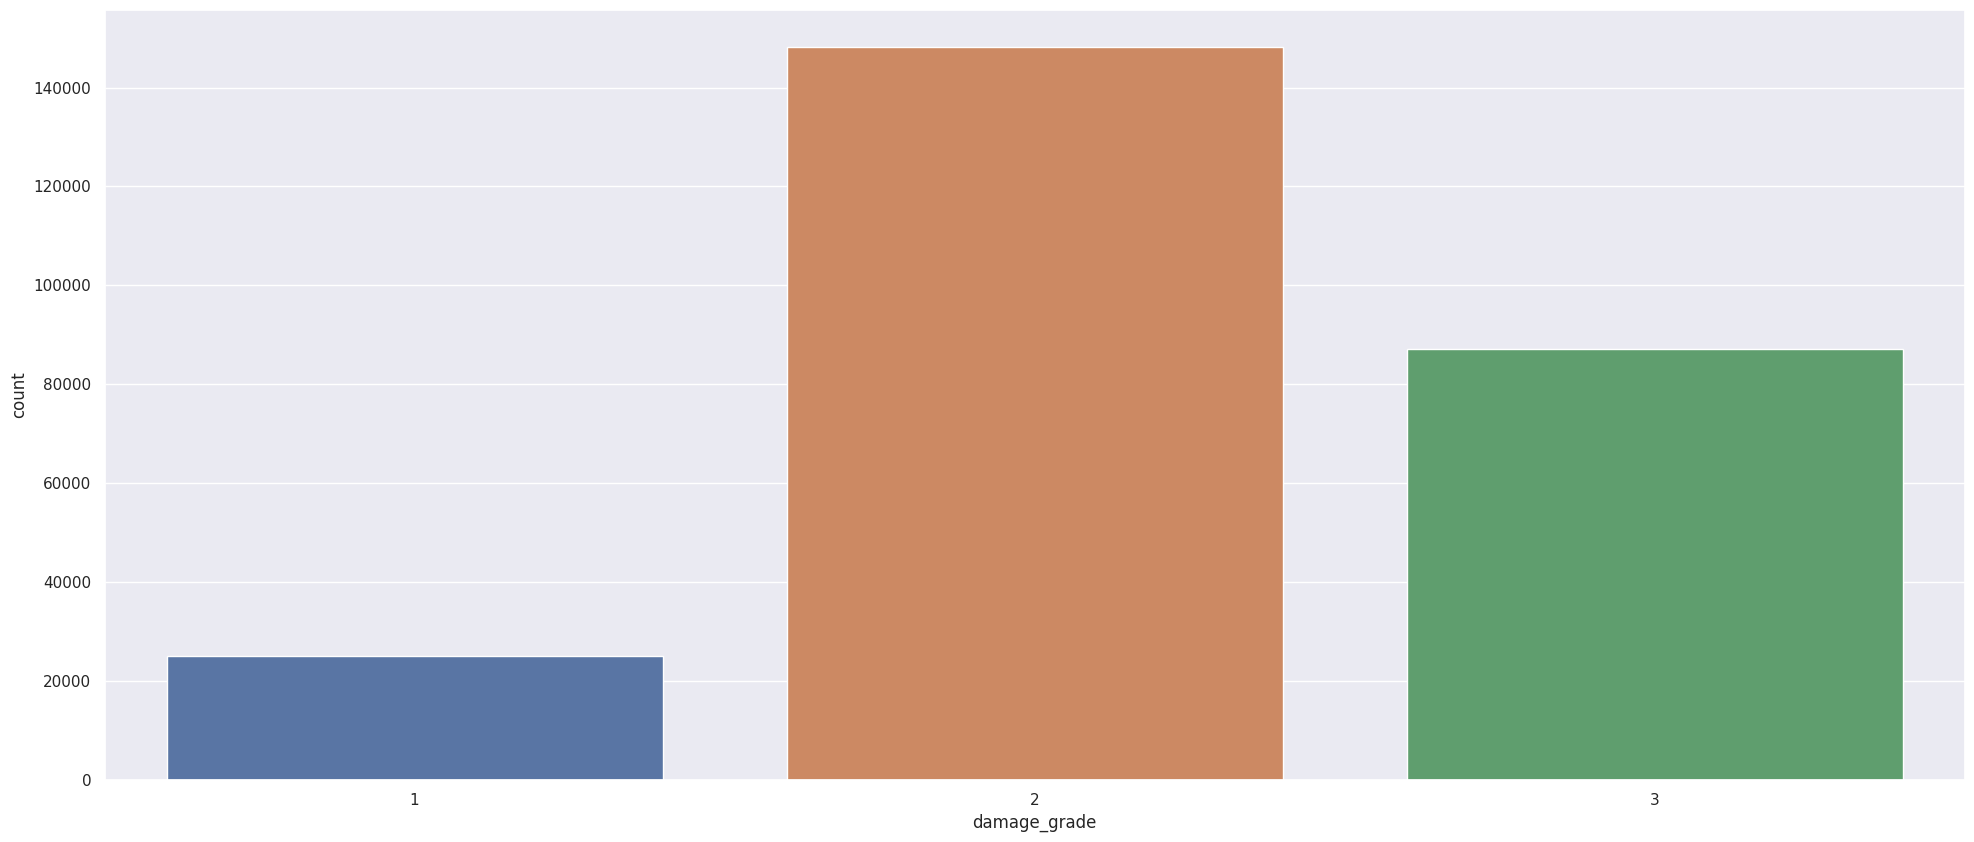

In [ ]:
sns.countplot(x=train_label.damage_grade)

# need to deal with imblance.

### geo_level 1~3

<Axes: xlabel='geo_level_1_id', ylabel='count'>

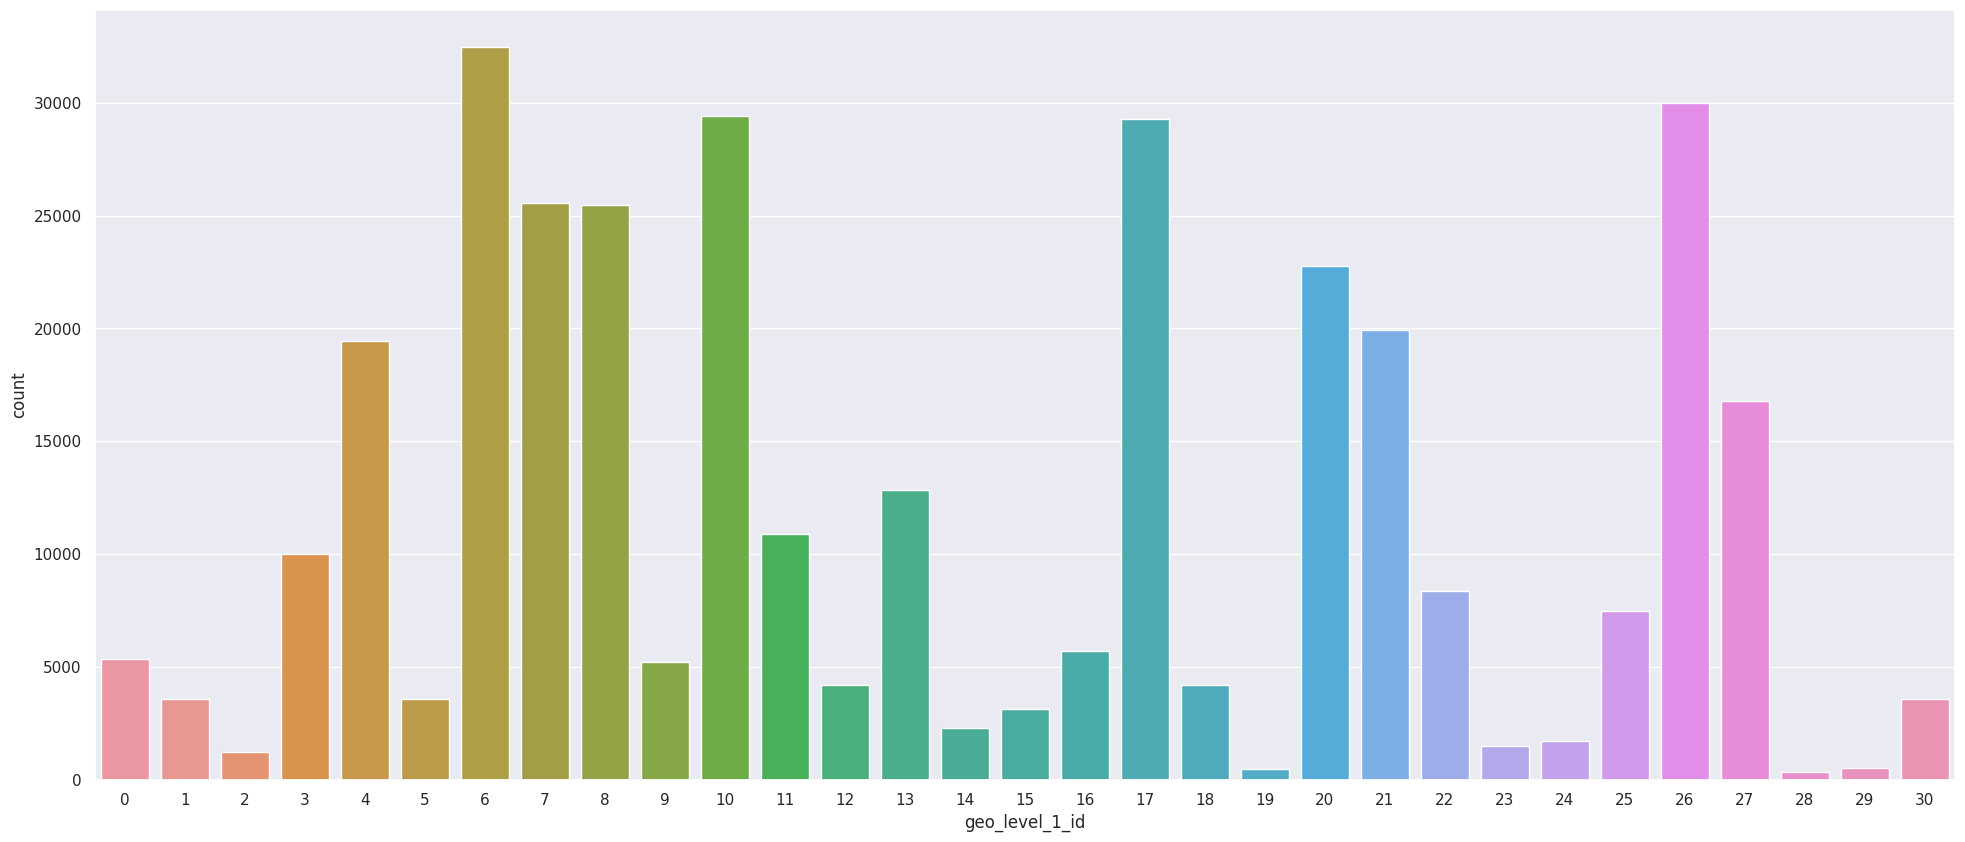

In [ ]:
# maybe it can present big_city or country,
# or distance toward Epicenter.
# So, whether these damaged_building is in same area or not  is important. 

sns.countplot(x=f_dta.geo_level_1_id)


<Axes: xlabel='index', ylabel='geo_level_1_id'>

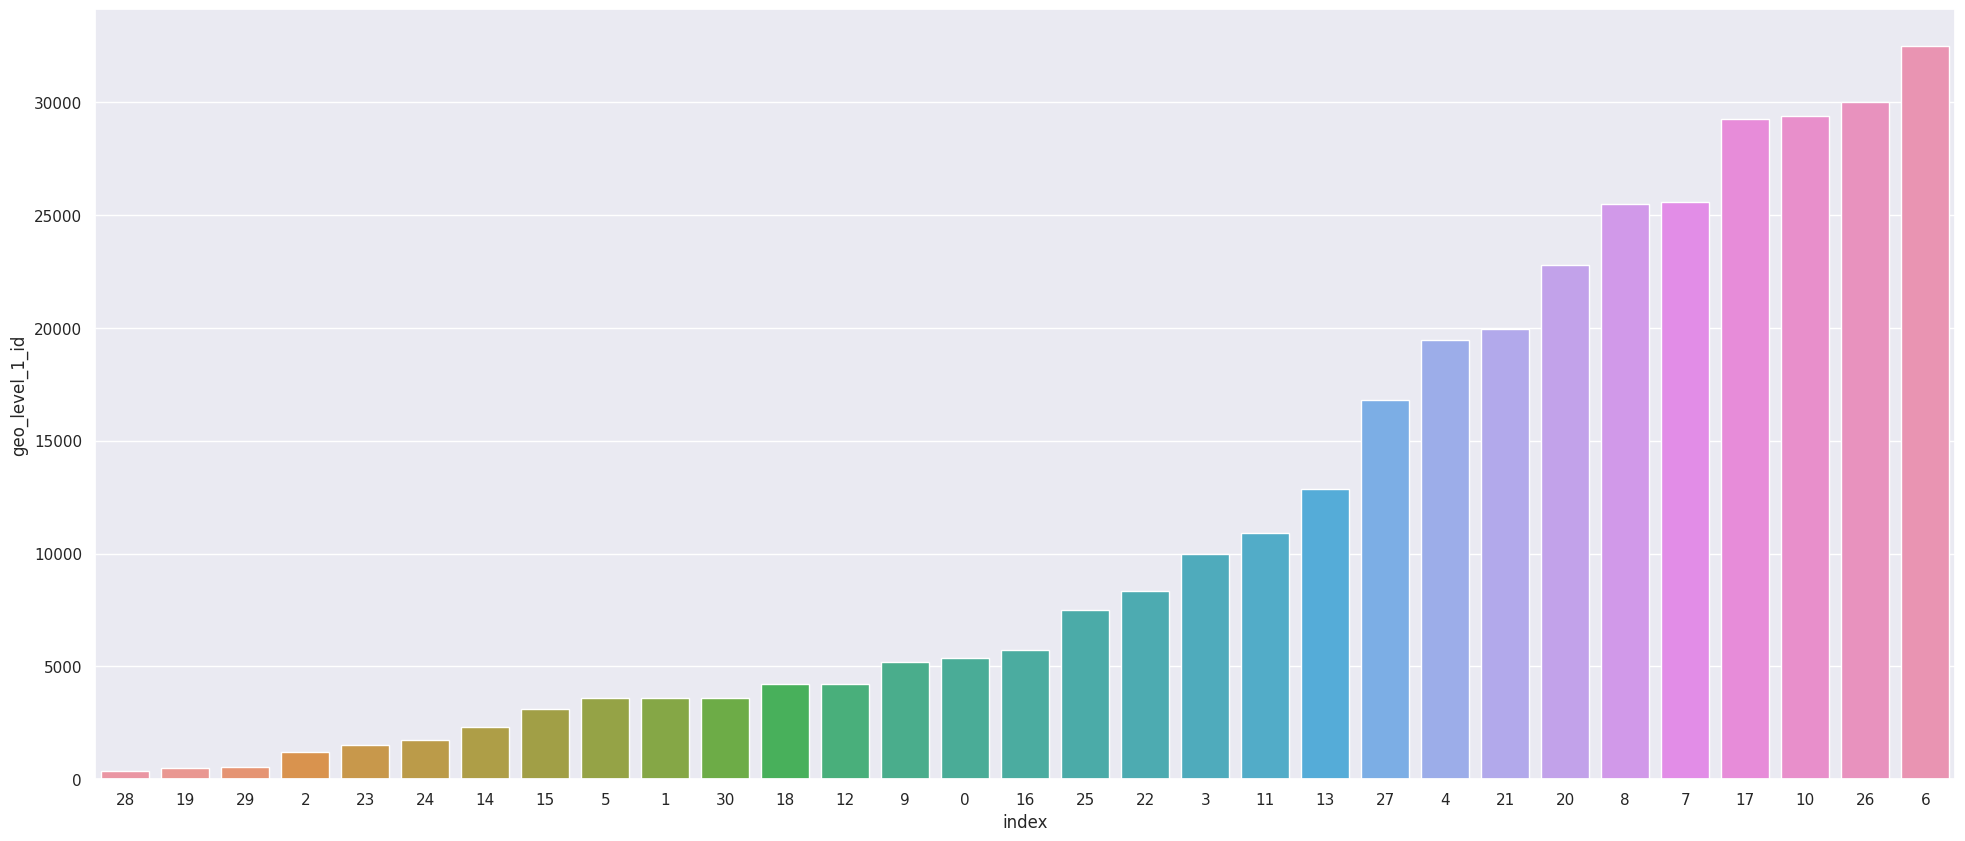

In [ ]:
g1_count = f_dta.geo_level_1_id.value_counts().sort_values().reset_index()
sns.barplot(x=g1_count['index'],y=g1_count.geo_level_1_id,order=g1_count['index'])

#in some area, it damaged heavier than others.  maybe it can make cluster,

### count_floors_pre_eq

<Axes: xlabel='count_floors_pre_eq', ylabel='count'>

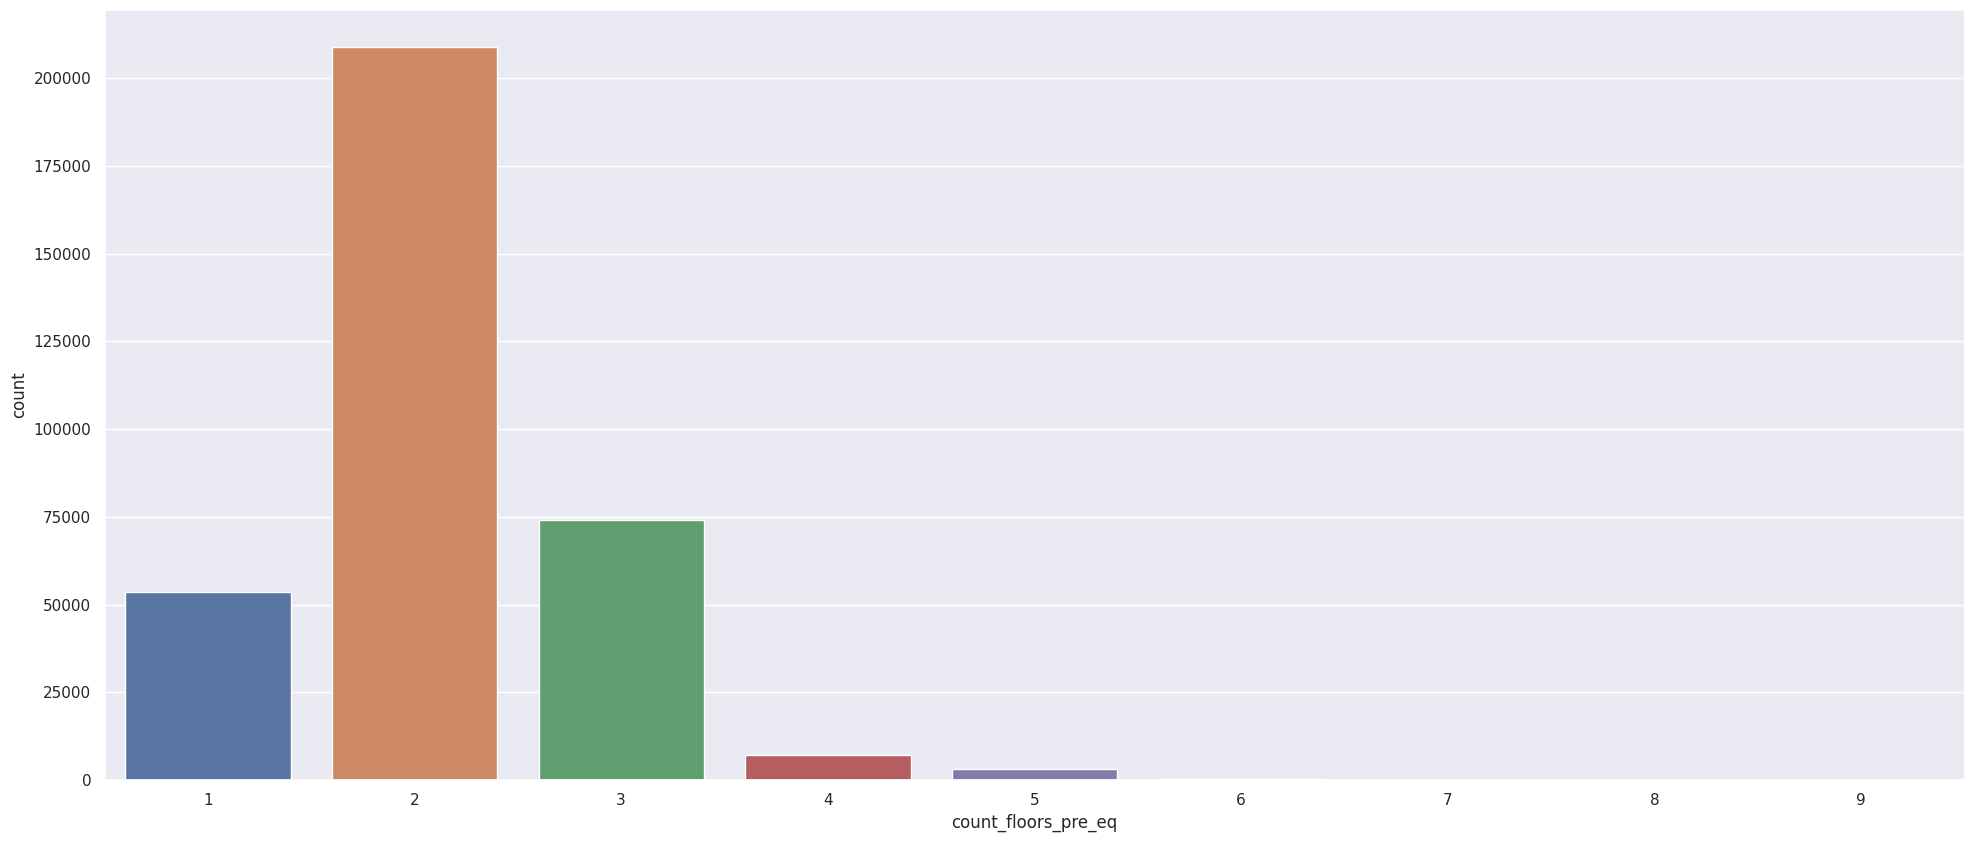

In [ ]:
sns.countplot(x=f_dta.count_floors_pre_eq)

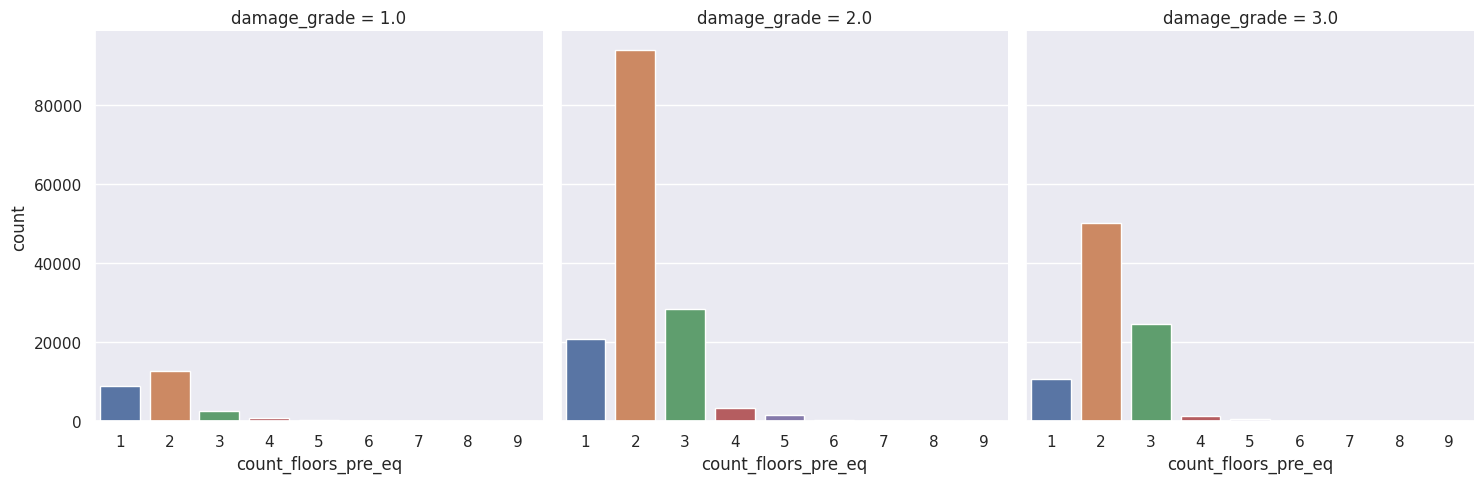

In [ ]:
sns.catplot(x='count_floors_pre_eq',kind='count',col='damage_grade',data=pd.concat([f_dta.count_floors_pre_eq,train_label.damage_grade],axis=1))

#as we know,most building are classifeid as damage_grade_2
#and two floors building is most. 

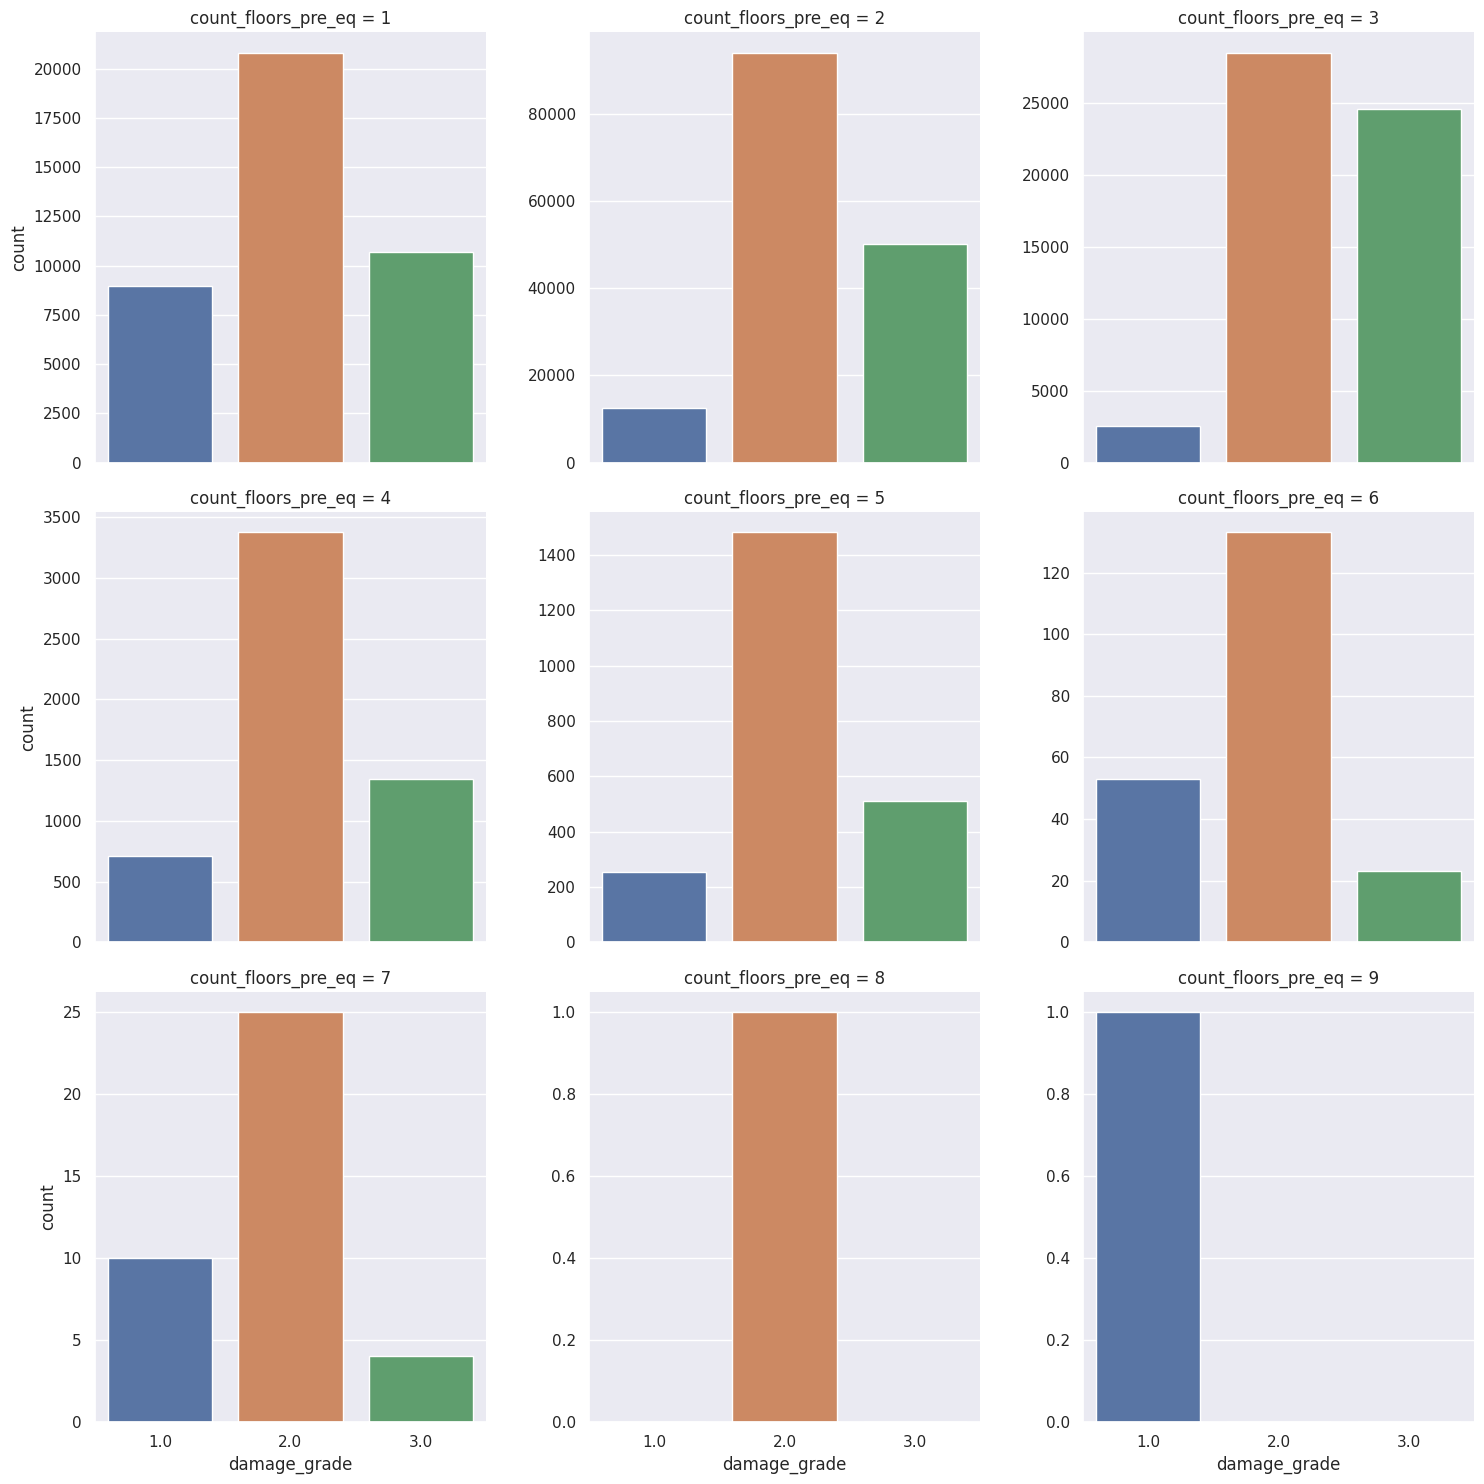

In [ ]:
sns.catplot(x='damage_grade',kind='count',col='count_floors_pre_eq',data=pd.concat([f_dta.count_floors_pre_eq,train_label.damage_grade],axis=1),col_wrap=3,sharey=False)

# Conclusion 1:
according to expert knowledge,
<br>In smaller earthquake,higher floors's damage will not be as heavy as lower floor,
<br>1~3 floors will take more damage than higher floors.
<br>and the first floor will take the most damage.<br>
<br>But if In heavier earthquake (which means most buildings cannot afford shake),
<br>1 floor will damage less than higher floor.(because higher floor had falled down already.)<br>
<br>according to figure, level 2 damage is the most, level 3 is second. Which meets the expert knowledge.

#### Building Age

<Axes: xlabel='age', ylabel='count'>

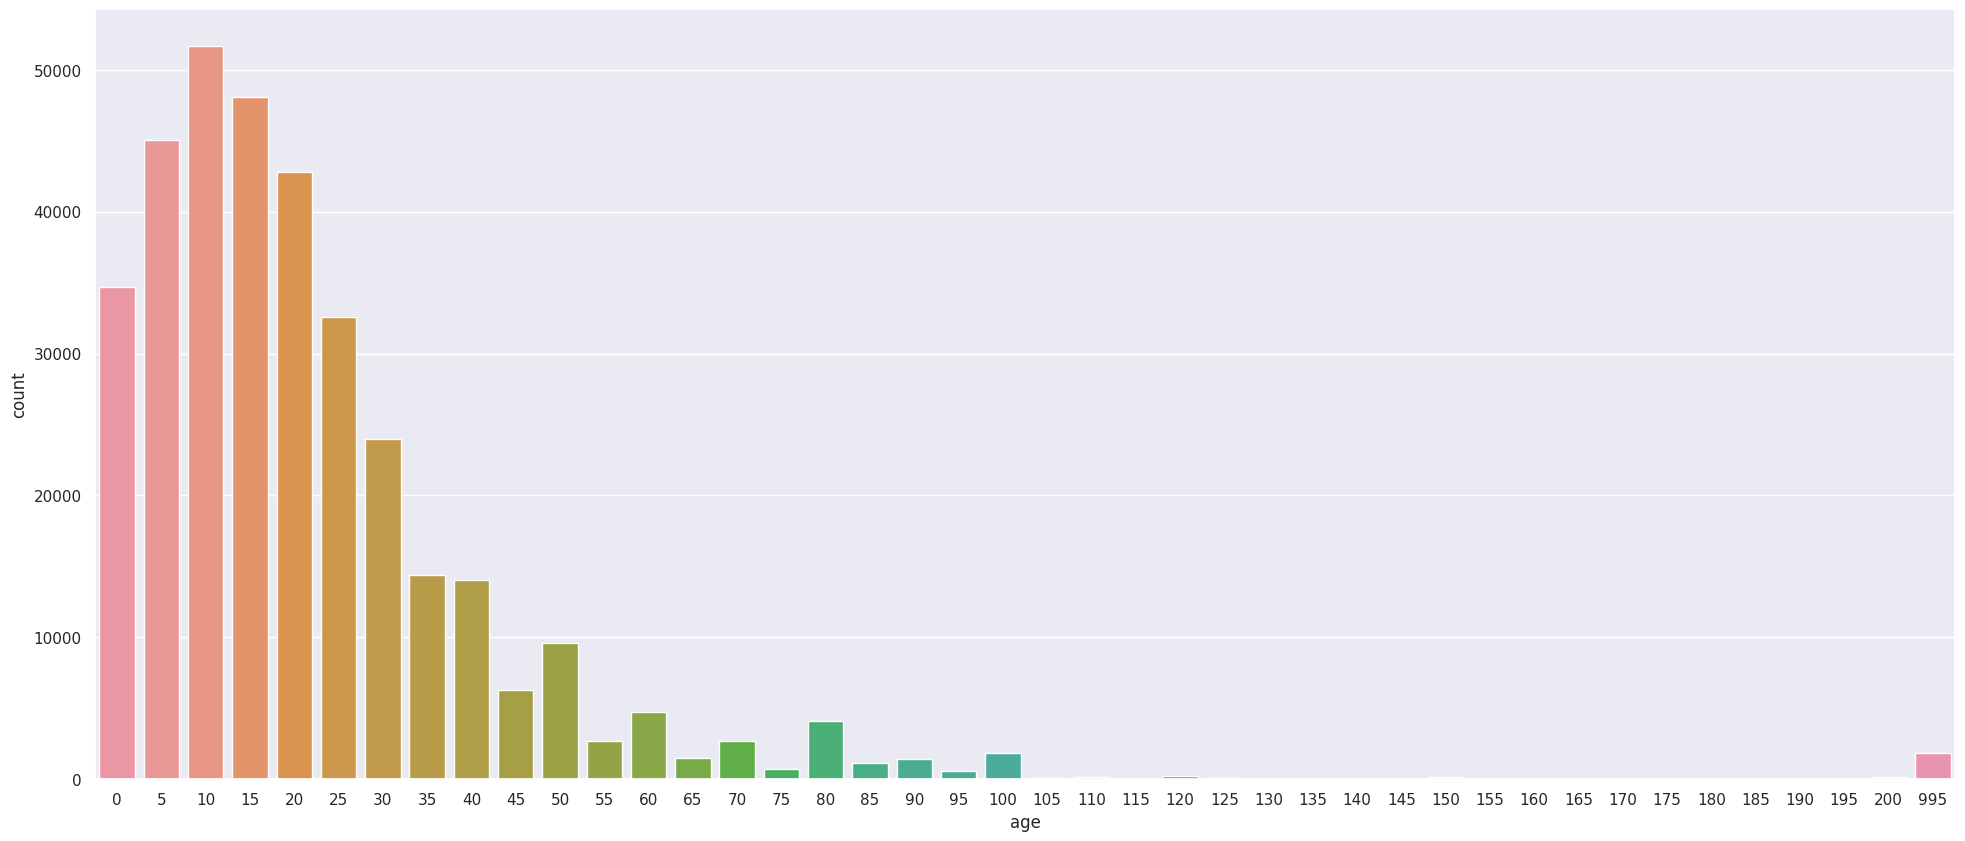

In [ ]:
sns.set(rc={'figure.figsize':(24,10)})
sns.countplot(x=f_dta.age)


# we have a outliner 995.
#According to local news, it should be a thousand-years temple which damage in earthquake. 
#But 995 also in test data set.So I think I had better keep it, and create a columns for it.
#And tree-based algorithm can handle out-liner,xgboost is an options.  

<Axes: xlabel='height_percentage', ylabel='count'>

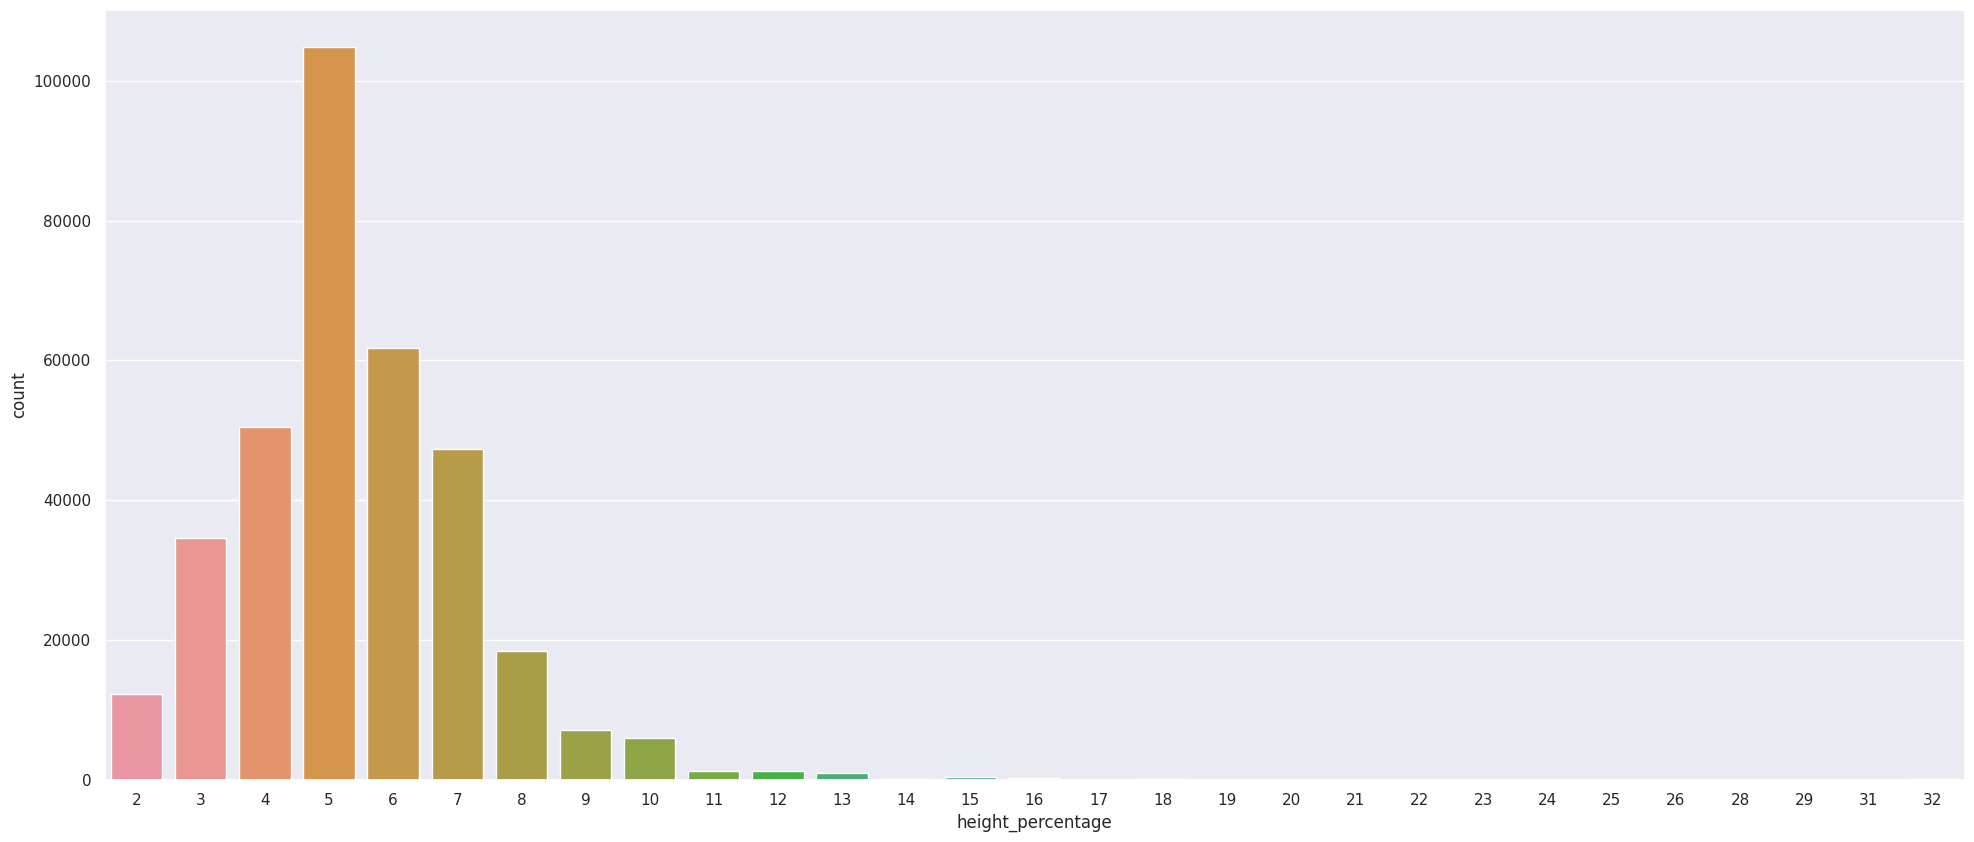

In [ ]:
sns.countplot(x=f_dta.height_percentage)

<Axes: xlabel='area_percentage', ylabel='count'>

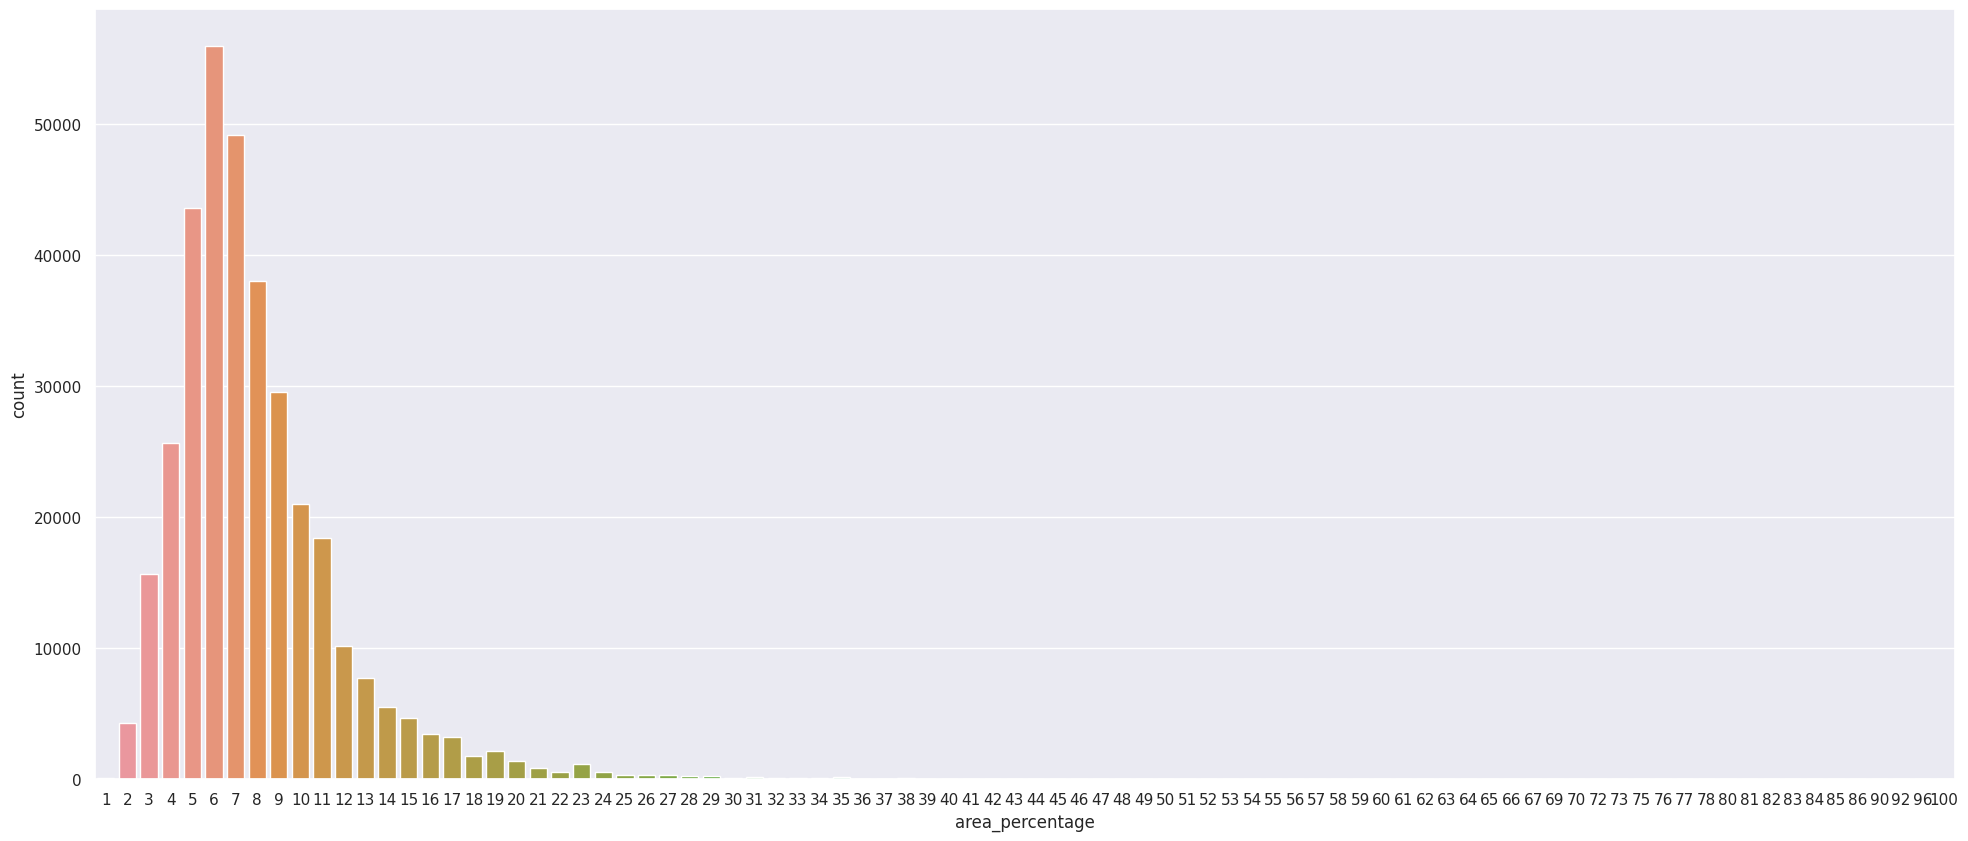

In [ ]:
sns.countplot(x=f_dta.area_percentage)

In [ ]:
f_dta['age_995'] = (f_dta.age > 200).astype(int)

### area_percentage

<ipython-input-136-eaccf06f7246>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(f_dta['area_percentage'])


<Axes: xlabel='area_percentage', ylabel='Density'>

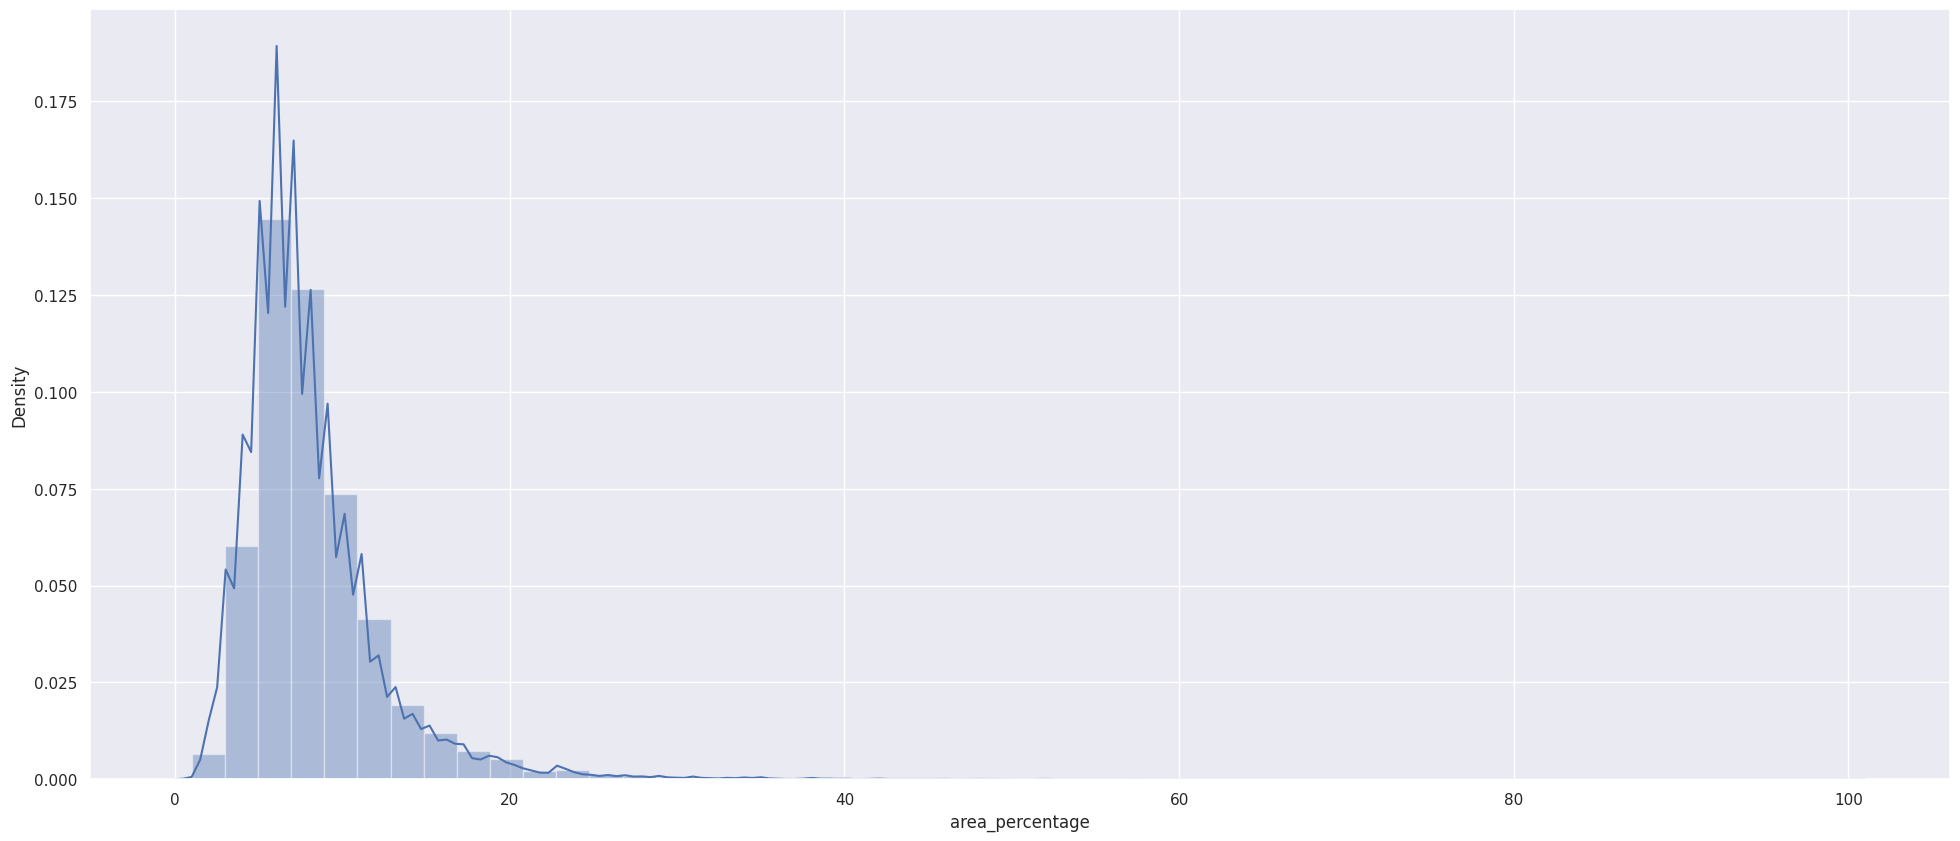

In [ ]:
#According the explanation on website,it has been nornalized.
sns.distplot(f_dta['area_percentage'])

<Axes: xlabel='area_percentage', ylabel='count'>

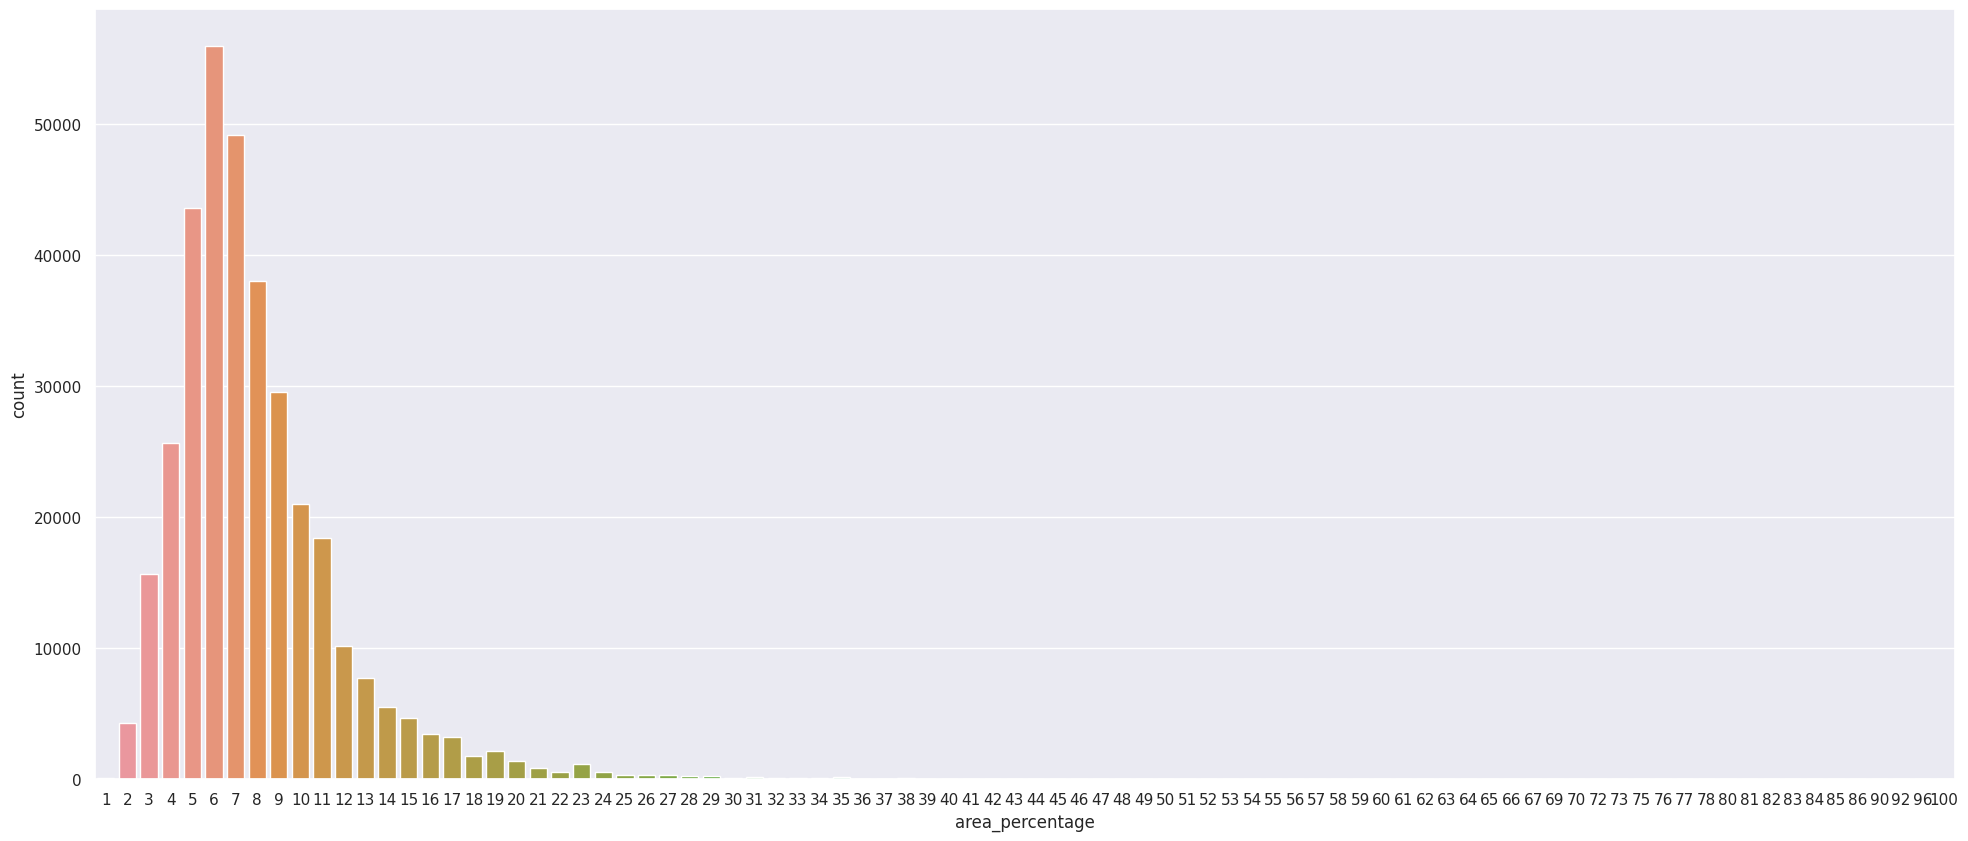

In [ ]:
sns.countplot(x=f_dta['area_percentage'])

### height_percentage 

<ipython-input-138-aafff32252cb>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(f_dta['height_percentage'])


<Axes: xlabel='height_percentage', ylabel='Density'>

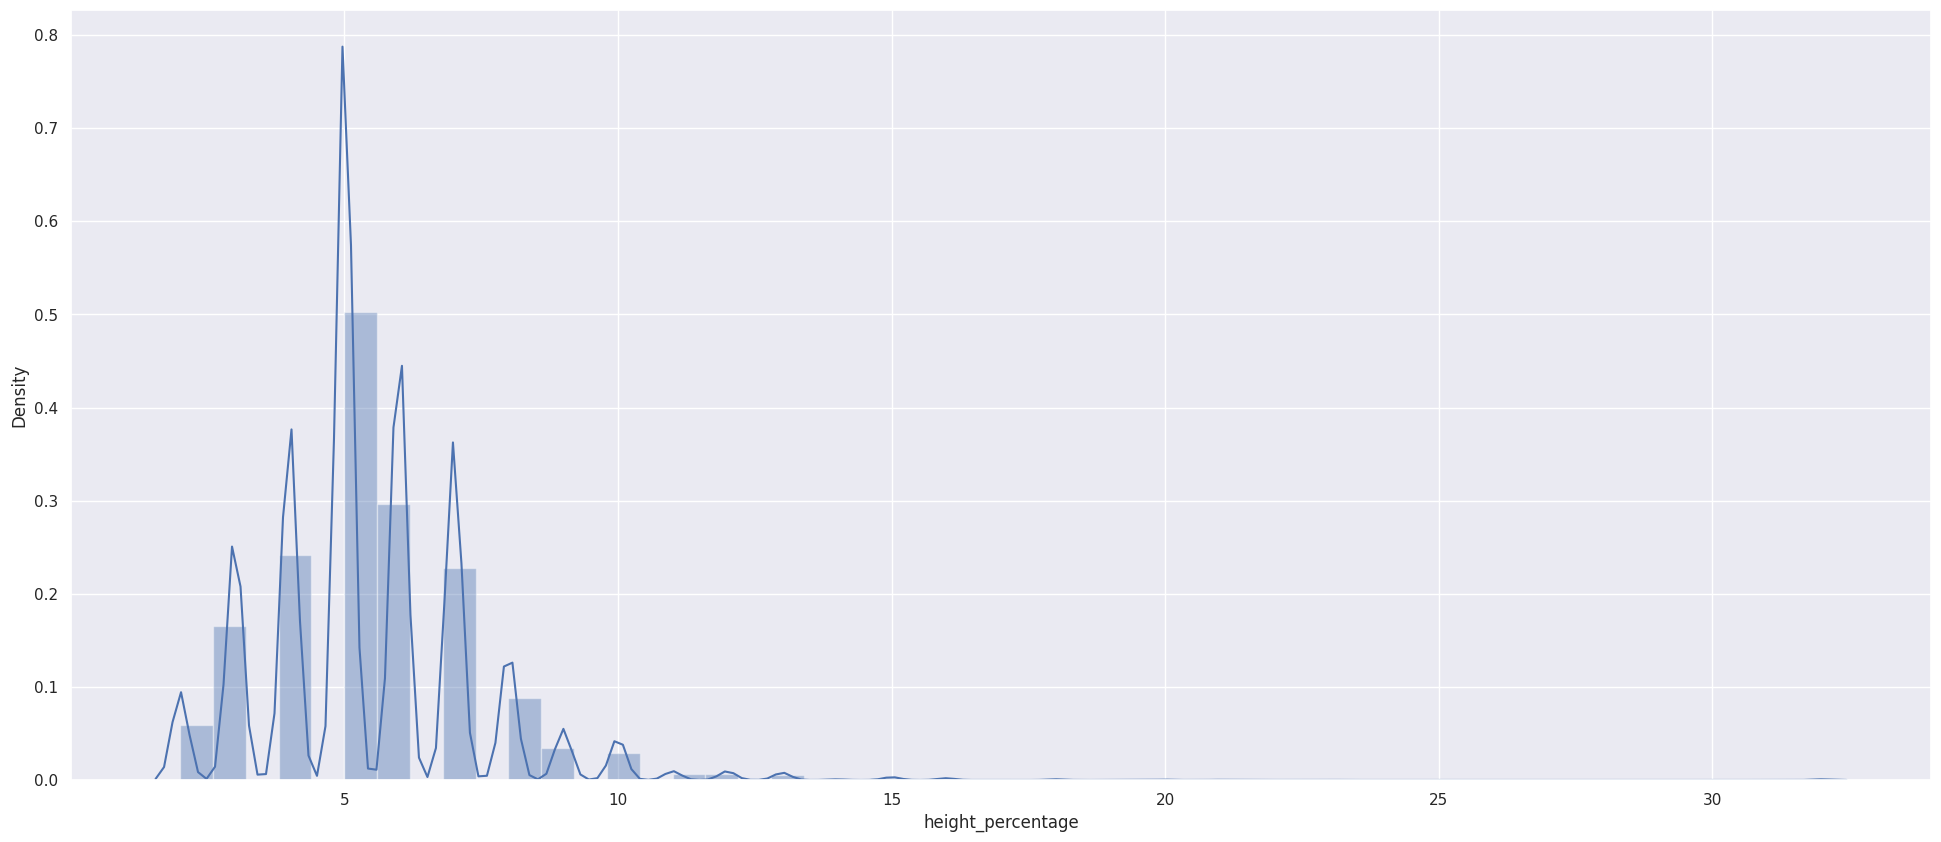

In [ ]:
#According the explanation on website,it has been nornalized.
sns.distplot(f_dta['height_percentage'])

<Axes: xlabel='height_percentage', ylabel='count'>

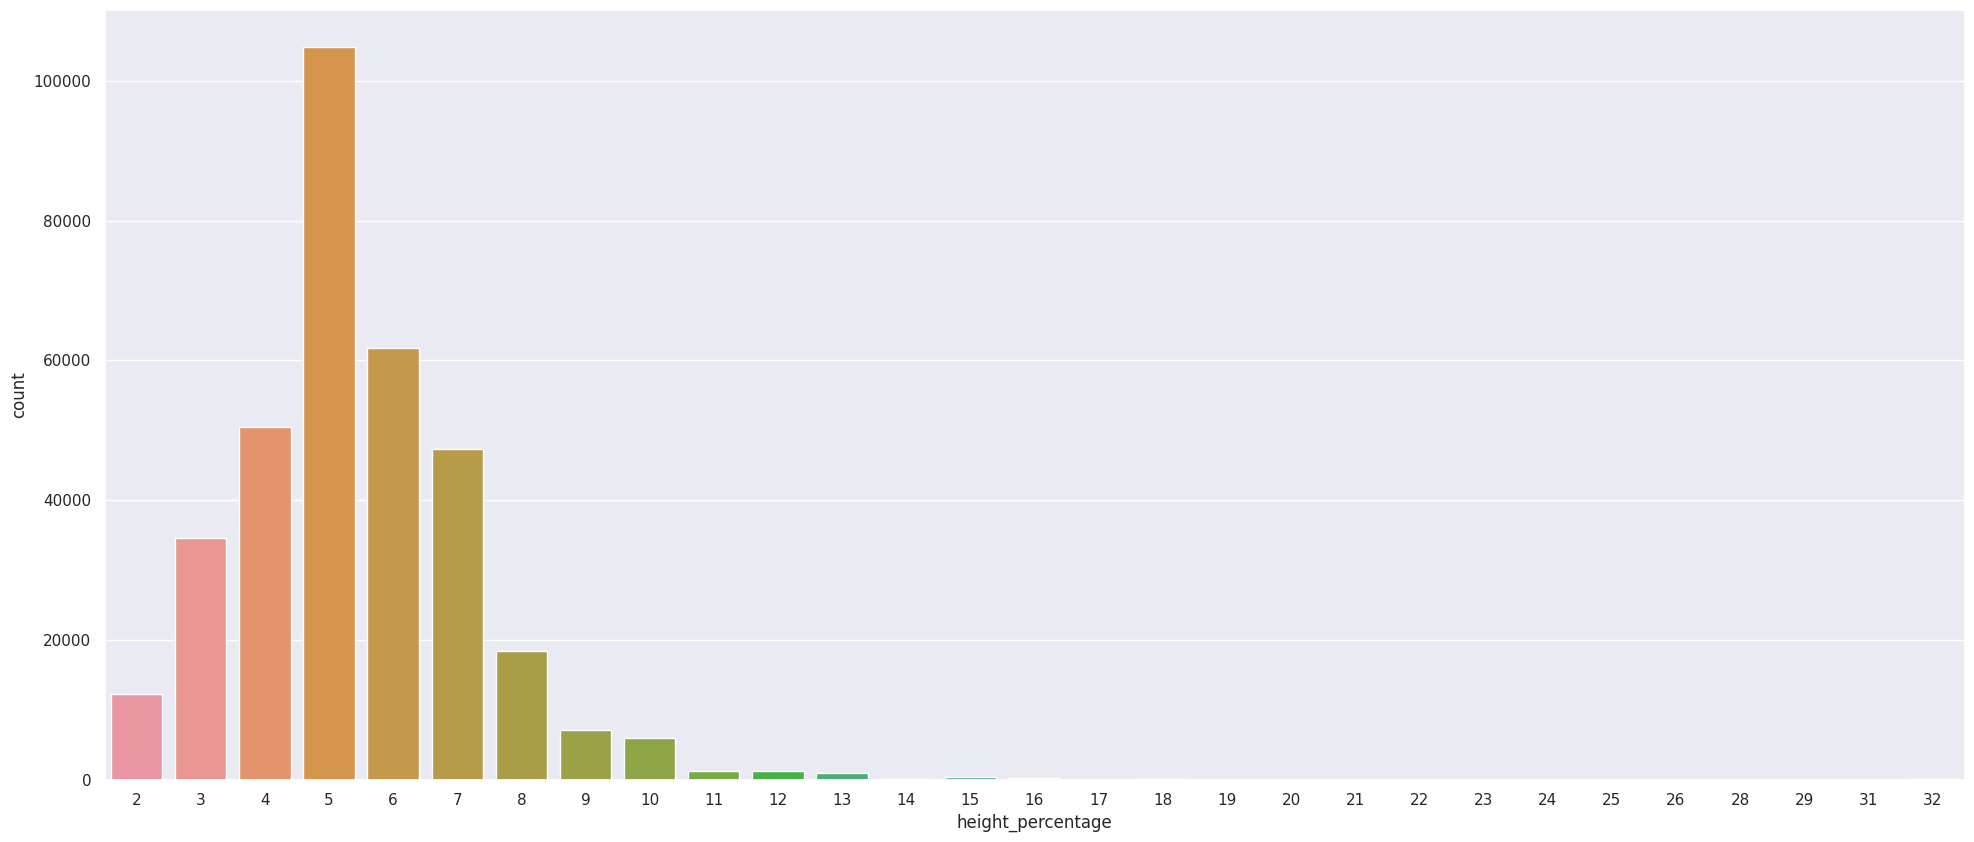

In [ ]:
sns.countplot(x=f_dta['height_percentage'])

### count_families

<Axes: xlabel='count_families', ylabel='count'>

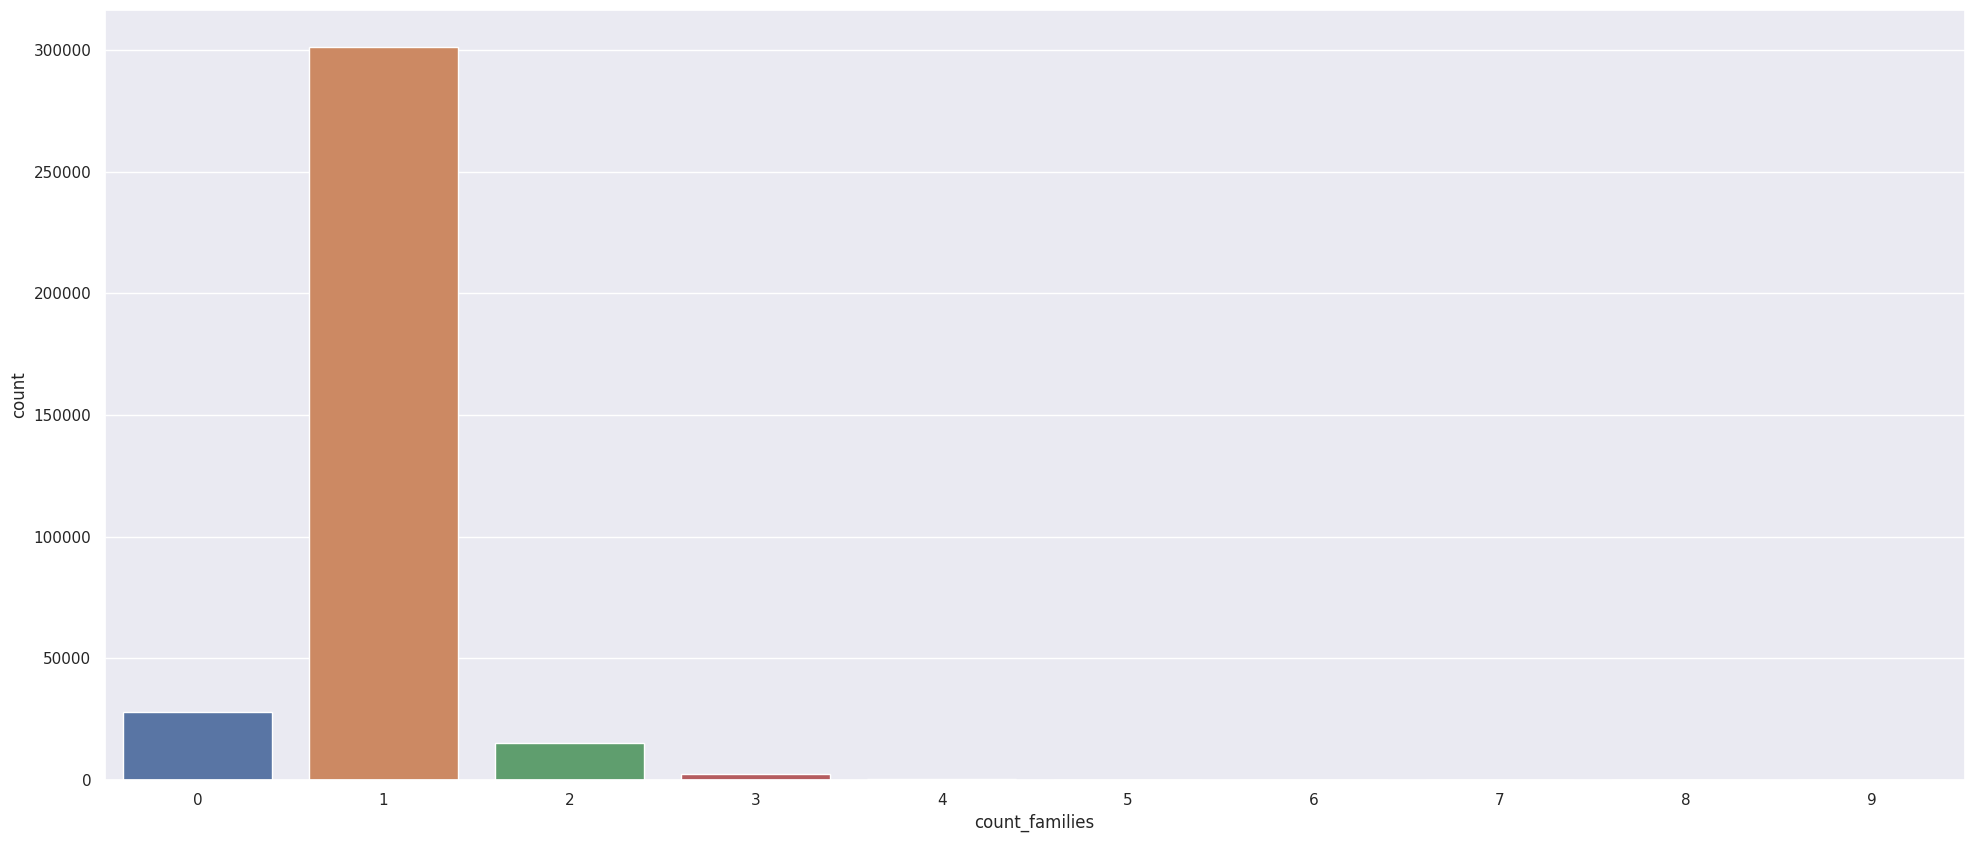

In [ ]:
# count_families:number of families that live in the building
# No family in that building: maybe all rooms in that building is single_room, or it only has one room.
# 1 family in that building: It may be owned by a family, So it is a 1~3 floors house. 
# more than 2 family in that building: It may be a departmant.Or It can not cantain so many people. 
#So i will seperate count_familes into 3 category.

sns.countplot(x=f_dta['count_families'])

### land_surface_condition 

<Axes: xlabel='land_surface_condition', ylabel='count'>

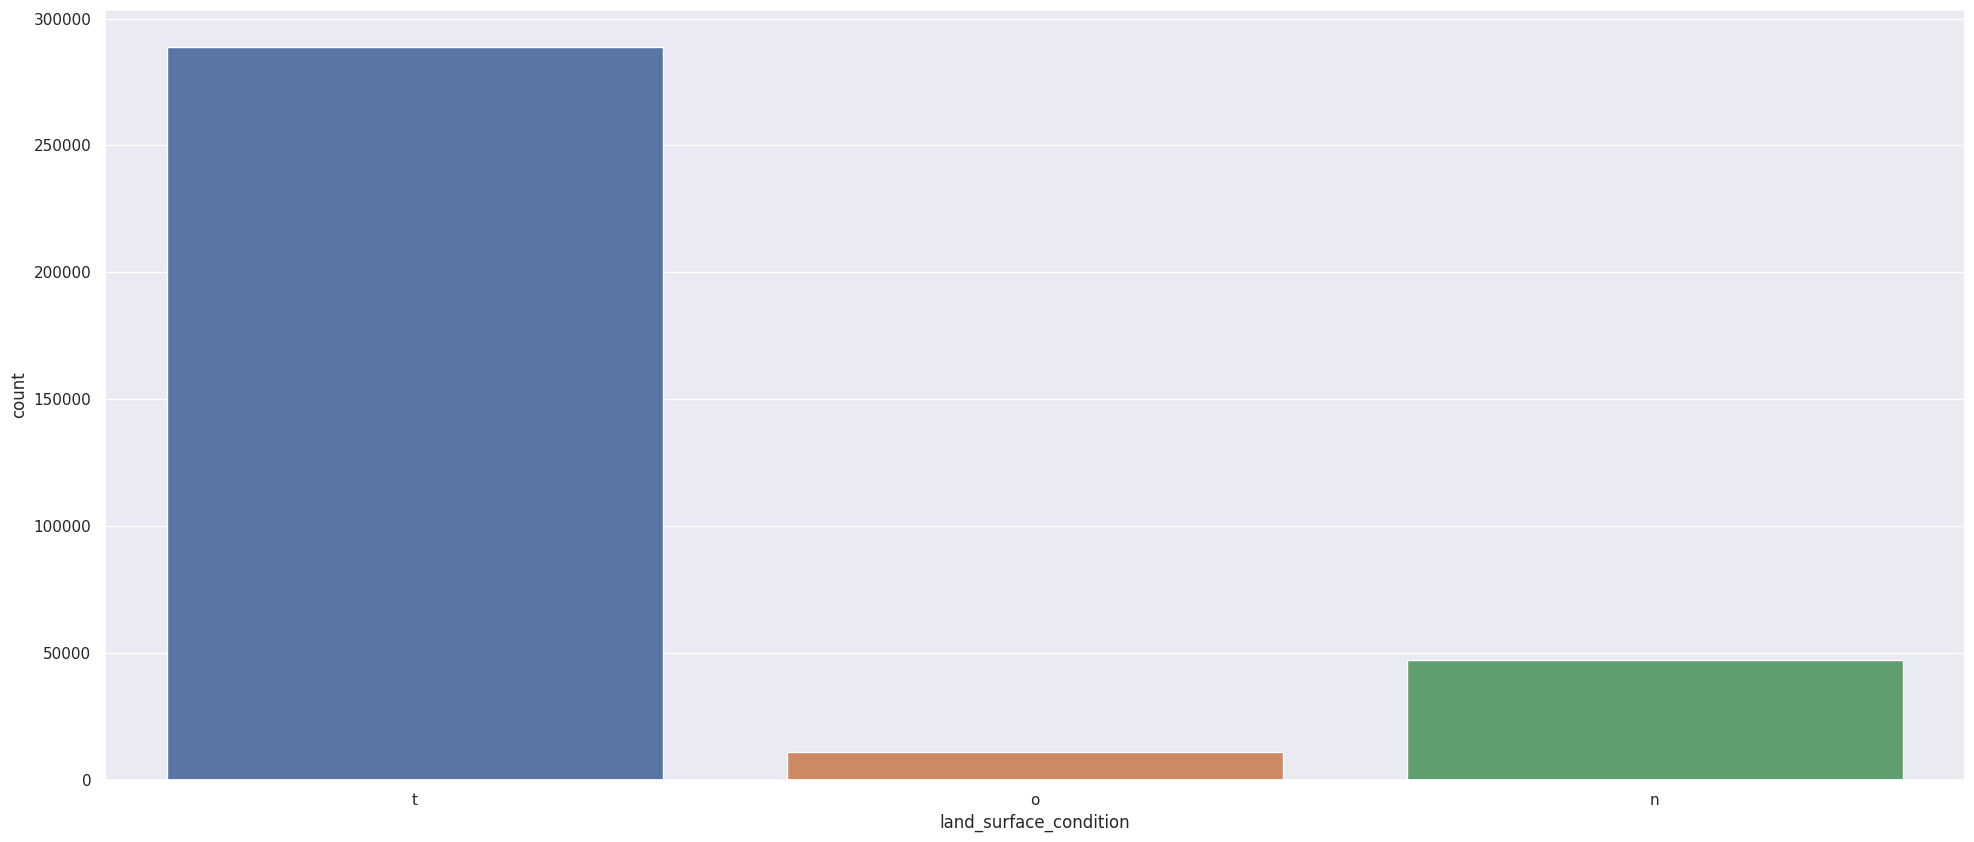

In [ ]:
sns.countplot(x=f_dta['land_surface_condition'])

#can not get more information.
#the others Variables is the same condition.

#processing feature engineering:
#1.add group mean and group count
#2.do some label encoding or one-hot encoding. (later)

### geo_level :  Mean Encoding

In [ ]:
# only use train data to count geo_level
train = pd.concat([train_values,train_label],axis=1)
train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,train_data,building_id,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,...,0,0,0,0,0,0,0,1,802906,3
1,28830,8,900,2812,2,10,8,7,o,r,...,0,0,0,0,0,0,0,1,28830,2
2,94947,21,363,8973,2,10,5,5,t,r,...,0,0,0,0,0,0,0,1,94947,3
3,590882,22,418,10694,2,10,6,5,t,r,...,0,0,0,0,0,0,0,1,590882,2
4,201944,11,131,1488,3,30,8,9,t,r,...,0,0,0,0,0,0,0,1,201944,3


In [ ]:
def group_mean_n_count(data,column):  
    # count mean & n with to sepeific columns.
    
    result_mean = data.groupby(column).mean()['damage_grade'].reset_index()
    result_mean.columns = column + ['&'.join(column)+'_mean']

    result_count = data.groupby(column).count()['damage_grade'].reset_index()
    result_count.columns = column + ['&'.join(column)+'_count']
    
    return result_mean,result_count

In [ ]:
#geo_1_damage_mean,geo_1_damage_count = group_mean_n_count(train,['geo_level_1_id'])

### level_1 & level_2 need to ne use, to determine targer of that area.
#geo_2_damage_mean,geo_2_damage_count = group_mean_n_count(train,['geo_level_1_id','geo_level_2_id'])  

#geo_3_damage_mean,geo_3_damage_count = group_mean_n_count(train,['geo_level_1_id','geo_level_2_id','geo_level_3_id'])

In [ ]:
#save to f_dta table (which will be using in modeling)
f_dta2 = f_dta.copy()
#f_dta2 = f_dta2.merge(geo_1_damage_mean,on='geo_level_1_id',how='left')
#f_dta2 = f_dta2.merge(geo_1_damage_count,on='geo_level_1_id',how='left')

#f_dta2 = f_dta2.merge(geo_2_damage_mean,on=['geo_level_1_id','geo_level_2_id'],how='left')
#f_dta2 = f_dta2.merge(geo_2_damage_count,on=['geo_level_1_id','geo_level_2_id'],how='left')
#f_dta2 = f_dta2.merge(geo_3_damage_mean,on=['geo_level_1_id','geo_level_2_id','geo_level_3_id'],how='left')
#f_dta2 = f_dta2.merge(geo_3_damage_count,on=['geo_level_1_id','geo_level_2_id','geo_level_3_id'],how='left')

### others categorial variables (roof_type,has_something....) : Mean Encoding 

In [ ]:
one_hot_col=['land_surface_condition',
         'foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration', 'legal_ownership_status']
binary_col=[
 'has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'has_secondary_use',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 #'has_secondary_use_other']
 'has_secondary_use_other','age_995']

# Numinal Variables

In [ ]:
#category columns
geo_col = ['geo_level_1_id','geo_level_2_id','geo_level_3_id']
#geo_col = ['geo_level_1_id','geo_level_2_id','geo_level_3_id','geo_level_1_id_mean','geo_level_1_id_count','geo_level_1_id&geo_level_2_id_mean','geo_level_1_id&geo_level_2_id_count','geo_level_1_id&geo_level_2_id&geo_level_3_id_mean','geo_level_1_id&geo_level_2_id&geo_level_3_id_count']
cat_col= geo_col+one_hot_col+binary_col

In [ ]:
num_cols = [
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage', 
 'count_families']

In [ ]:
f_dta3 = f_dta2.copy()
cat_col=[]
for c in f_dta3.columns:
    if c not in num_cols:
        cat_col.append(c)
cat_col.remove('building_id')
cat_col.remove('train_data')
#Remember building_id train_data do not enter the model.


# use Label Encoder,OneHot-Encoder and StandardScaler to tranfrom data

In [ ]:
f_dta4 = f_dta3.copy()
for c ,d in zip(f_dta4.columns,f_dta4.dtypes):
    if c in geo_col:
        #geo col has too many columns so use label_encoder
        if  c == 'geo_level_1_id':
            #f_dta4 = pd.concat([f_dta4,pd.get_dummies(f_dta4[[c]])],axis=1)   
            #f_dta4.drop(columns=[c],inplace=True)
            pass
        else:
            #f_dta4.drop(columns=[c],inplace=True)
            pass
        
    elif c in one_hot_col:
        f_dta4 = pd.concat([f_dta4,pd.get_dummies(f_dta4[[c]])],axis=1)
        f_dta4.drop(columns=[c],inplace=True)
        pass
        
    elif c in num_cols:
        f_dta4[c] = StandardScaler().fit_transform(f_dta4[[c]].to_numpy()).flatten()
        pass
    elif c in binary_col:
        #binary col do not need to transform
        pass
    
    else:
        print(c,' not process.')

building_id  not process.
train_data  not process.


# train model

In [ ]:
print(f_dta4.columns)
f_dta4.drop(columns=['building_id'],inplace=True)

Index(['building_id', 'geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'train_data', 'age_995',


In [ ]:
#there is some na.
f_dta4.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347469 entries, 0 to 347468
Data columns (total 70 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   geo_level_1_id                          347469 non-null  int64  
 1   geo_level_2_id                          347469 non-null  int64  
 2   geo_level_3_id                          347469 non-null  int64  
 3   count_floors_pre_eq                     347469 non-null  float64
 4   age                                     347469 non-null  float64
 5   area_percentage                         347469 non-null  float64
 6   height_percentage                       347469 non-null  float64
 7   has_superstructure_adobe_mud            347469 non-null  int64  
 8   has_superstructure_mud_mortar_stone     347469 non-null  int64  
 9   has_superstructure_stone_flag           347469 non-null  int64  
 10  has_superstructure_cement_mortar_stone  3474

<ipython-input-181-aaabf06a913e>:2: FutureWarning: null_counts is deprecated. Use show_counts instead
  f_dta4.info(verbose=True, null_counts=True)


In [ ]:
#for c in ['geo_level_1_id&geo_level_2_id_mean','geo_level_1_id&geo_level_2_id_count','geo_level_1_id&geo_level_2_id&geo_level_3_id_mean','geo_level_1_id&geo_level_2_id&geo_level_3_id_count']:
#    f_dta4[c] = f_dta4[c].fillna(f_dta4[c].mean())
        

In [ ]:
train_data = f_dta4[f_dta4.train_data == 1]
test_data = f_dta4[f_dta4.train_data == 0]

train_data.drop(columns=['train_data'],inplace=True)
test_data.drop(columns=['train_data'],inplace=True)

<ipython-input-183-0c523a0f4a6d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns=['train_data'],inplace=True)
<ipython-input-183-0c523a0f4a6d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(columns=['train_data'],inplace=True)


## variable select

In [ ]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_label.damage_grade = le.fit_transform(train_label.damage_grade)

#model = XGBRegressor(
#    tree_method='gpu_hist',
#    seed=SEED,
#    learning_rate=0.01,
#    n_estimators=1600, 
#    subsample=0.7,
#    objective='multi:softmax',
#    num_class=3).fit(train_data,train_label.damage_grade)

In [ ]:
#plot_importance(model,
#                height=0.5,
#                max_num_features=30)

In [ ]:
#imp = model.get_booster().get_score(importance_type='gain')

In [ ]:
#imp_table = pd.DataFrame({
#    'key':list(imp.keys()),
#    'value':list(imp.values())}).sort_values(by='value',ascending=False)

#imp_table

In [ ]:
#choose_col_n=len(imp_table)
#choose_col_n = 20
#imp_col = imp_table.key[0:choose_col_n]

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
#train_x,val_x,train_y,val_y = train_test_split(train_values, train_label, test_size=0.25)
ros = RandomOverSampler(random_state=SEED)
X_resampled, y_resampled = ros.fit_resample(train_data[imp_col], train_label.damage_grade)

KeyError: ignored

In [ ]:
train_x,val_x,train_y,val_y = train_test_split(X_resampled,y_resampled,random_state=SEED,test_size=0.25)

In [ ]:
#eval_set = [(train_x, train_y), (val_x, val_y)]
#progress = dict()
#model = XGBRegressor(
#    tree_method='gpu_hist',
#    seed=SEED,
#    learning_rate=0.01,
#    n_estimators=1600, 
#    subsample=0.7,
#    objective='multi:softmax',
#    num_class=3)

#model = model.fit(train_x[imp_col],train_y)
#print(f1_score(y_pred=model.predict(val_x[imp_col]),y_true=val_y.to_numpy(),average='micro'))

In [ ]:
#ans = pd.DataFrame({
#    'building_id':test.building_id,
#    'damage_grade':model.predict(test_data[imp_col])
#}).to_csv('submission_1214.csv',index=False)

In [ ]:
import pickle

In [ ]:
# save model to file
#pickle.dump(model, open("model1214", "wb"))
 
# load model from file
#loaded_model = pickle.load(open("model1214", "rb"))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

def score(m, x_train, y_train, x_test, y_test, train=True):
    if train:
        pred=m.predict(x_train)
        print('Train Result:\n')
        print(f"Accuracy Score: {accuracy_score(y_train, pred)*100:.2f}%")
        print(f"Precision Score: {precision_score(y_train, pred,average='micro')*100:.2f}%")
        print(f"Recall Score: {recall_score(y_train, pred,average='micro')*100:.2f}%")
        print(f"F1 score: {f1_score(y_train, pred,average='micro')*100:.2f}%")
        print(f"Confusion Matrix:\n {confusion_matrix(y_train, pred)}")
    elif train == False:
        pred=m.predict(x_test)
        print('Test Result:\n')
        print(f"Accuracy Score: {accuracy_score(y_test, pred)*100:.2f}%")
        print(f"Precision Score: {precision_score(y_test, pred,average='micro')*100:.2f}%")
        print(f"Recall Score: {recall_score(y_test, pred,average='micro')*100:.2f}%")
        print(f"F1 score: {f1_score(y_test, pred,average='micro')*100:.2f}%")
        print(f"Confusion Matrix:\n {confusion_matrix(y_test, pred)}")

In [ ]:
from sklearn import tree

tree1 = tree.DecisionTreeClassifier(
    max_depth=6)
#tree1 = tree1.fit(train_x, train_y)
#score(tree1, train_x, train_y, val_x, val_y, train=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(max_depth=8, n_estimators=1600, random_state= 42)
#forest = forest.fit(train_x, train_y)
#score(forest, train_x, train_y, val_x, val_y, train=False)

In [ ]:
from xgboost import XGBClassifier
#xg1 = XGBClassifier(
#    tree_method='gpu_hist',
#    seed=SEED,
#    learning_rate=0.01,
#    n_estimators=1600, 
#    subsample=0.7,
#    objective='multi:softmax',
#    num_class=3)
#xg1=xg1.fit(train_x, train_y)

#score(xg1, train_x, train_y, val_x, val_y, train=False)

In [ ]:
cat_cols=['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other',
       'count_families', 'has_secondary_use', 'has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other', 'geo_level_1_id_mean',
       'geo_level_1_id_count', 'geo_level_1_id&geo_level_2_id_mean',
       'geo_level_1_id&geo_level_2_id_count',
       'geo_level_1_id&geo_level_2_id&geo_level_3_id_mean',
       'geo_level_1_id&geo_level_2_id&geo_level_3_id_count',
       'land_surface_condition_n', 'land_surface_condition_o',
       'land_surface_condition_t', 'foundation_type_h', 'foundation_type_i',
       'foundation_type_r', 'foundation_type_u', 'foundation_type_w',
       'roof_type_n', 'roof_type_q', 'roof_type_x', 'ground_floor_type_f',
       'ground_floor_type_m', 'ground_floor_type_v', 'ground_floor_type_x',
       'ground_floor_type_z', 'other_floor_type_j', 'other_floor_type_q',
       'other_floor_type_s', 'other_floor_type_x', 'position_j', 'position_o',
       'position_s', 'position_t', 'plan_configuration_a',
       'plan_configuration_c', 'plan_configuration_d', 'plan_configuration_f',
       'plan_configuration_m', 'plan_configuration_n', 'plan_configuration_o',
       'plan_configuration_q', 'plan_configuration_s', 'plan_configuration_u',
       'legal_ownership_status_a', 'legal_ownership_status_r',
       'legal_ownership_status_v', 'legal_ownership_status_w']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
model = CatBoostClassifier(eval_metric='TotalF1', task_type="GPU",cat_features=f_dta4.columns)

#Choose parameters to test here
parameters = {'depth':[2,4,6,8,10,12],
            'iterations':[10,100,500,1000,5000],
            'learning_rate':[0.02,0.05,0.06,0.07], 
            'l2_leaf_reg':[3,5,7,9],
            'border_count':[11,13,15,17]}
print('Paramaters defined')

#Initialise the Gridsearch, cv is set to 2 for speed.
randm = GridSearchCV(estimator=model, param_grid = parameters,cv = 2)
randm.fit(train_x, train_y)

# Results from Random Search
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      randm.best_estimator_)

print("\n The best score across ALL searched params:\n",
      randm.best_score_)

print("\n The best parameters across ALL searched params:\n",
      randm.best_params_)

print("\n ========================================================")

In [ ]:
from sklearn.metrics import f1_score

print("Resample the train test split & try these parameters set")
#X = train_values; y = train_labels
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

#input best params here from randm.best_params_
model = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, silent=True, task_type="GPU",cat_features=cat_cols)
model.fit(train_x, train_y)
preds=model.predict(val_x)

#f1 score is the metric used in the competition
accuracy=f1_score(val_y,preds,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy)
print('\n Benchmark model was: 0.5815')

In [ ]:
from scipy.stats.mstats import winsorize
test_data["age"] = winsorize(test_data["age"],(0, 0.05))
test_data["area_percentage"] = winsorize(test_data["area_percentage"],(0, 0.055))
test_data["height_percentage"] = winsorize(test_data["height_percentage"],(0, 0.04))

ans = pd.DataFrame({
    'building_id':test.building_id,
    'damage_grade':(xg1.predict(test_data[imp_col])+1)
}).to_csv('submission_xg2win.csv',index=False)

In [ ]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist


# 建立模型

model = tf.keras.models.Sequential([
   tf.keras.layers.Dense(64, activation='relu'),
  
  
  tf.keras.layers.Dense(3, activation='softmax')
])


# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
#model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])

# 模型訓練
#model.fit(train_x, train_y, epochs=5)

#history = model.fit(train_x, train_y, epochs=5, validation_split=0.2)

#history = model.fit(train_x, train_y, epochs=10, validation_split=0.2)

#history = model.fit(train_x, train_y, epochs=128, validation_split=0.2)
# 模型評估，打分數
#model.evaluate(val_x, val_y)

In [ ]:

#ans = pd.DataFrame({
#    'building_id':test.building_id,
#    'damage_grade':(np.argmax(model.predict(test_data[imp_col]),axis=1)+1)
#}).to_csv('submission_xg1.csv',index=False)